In [11]:
import pandas as pd
import numpy as np
import shap
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from scripts import Preprocessor

In [12]:
p = Preprocessor('data_2')
dataframes = p.get_dataframes()

In [13]:
address = dataframes['address']
company = dataframes['company']
contract_person = dataframes['contact_person']
contract_authority = dataframes['contracting_authority']
offer = dataframes['offer']
procurement = dataframes['procurement']

In [14]:
df_for_pred = offer.copy()
df_for_pred = pd.merge(df_for_pred, procurement, left_on='procurement_id', right_on='id', how='left')
df_for_pred['is_winner'] = (df_for_pred['company_id'] == df_for_pred['supplier_id'])
df_for_pred.drop(columns=['id_y', 'procurement_id'], inplace=True)
df_for_pred = pd.merge(df_for_pred, company, left_on='company_id', right_on='id', how='left')
df_for_pred.drop(columns=['id'], inplace=True)
df_for_pred.drop(columns=['supplier_id', 'id_x', 'procurement_name', 'name_from_nipez_codelist', 'system_number', 'vat_id_number', 'company_name'], inplace=True)
df_for_pred = pd.merge(df_for_pred, contract_authority, left_on='contracting_authority_id', right_on='id', how='left')

In [15]:
df_for_simple = df_for_pred.drop(columns=['id', 'contract_price', 'contract_price_vat', 'price', 'price_vat']).copy()

In [16]:
categ = ['place_of_performance', 'public_contract_regime', 'type', 'type_of_procedure', 'address_id_x', 'address_id_y', 'url', 'contracting_authority_name', 'company_id', 'code_from_nipez_codelist','date_of_contract_close', 'contact_person_id', 'contracting_authority_id', 'organisation_id', 'bids_submission_deadline', 'date_of_publication']
for c in categ:
    df_for_simple[c].replace({np.nan : 'Unknown'}, inplace=True)

In [17]:
df_for_simple.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70338 entries, 0 to 70337
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   is_association_of_suppliers_x       70329 non-null  object 
 1   is_rejected_due_too_low             70330 non-null  object 
 2   is_withdrawn                        70329 non-null  object 
 3   company_id                          70338 non-null  int64  
 4   bids_submission_deadline            70338 non-null  object 
 5   code_from_nipez_codelist            70338 non-null  object 
 6   contract_price_with_amendments      70338 non-null  float64
 7   contract_price_with_amendments_vat  70338 non-null  float64
 8   date_of_contract_close              70338 non-null  object 
 9   date_of_publication                 70338 non-null  object 
 10  is_association_of_suppliers_y       70326 non-null  object 
 11  place_of_performance                70338

In [18]:
train_data = df_for_simple.drop(columns=["is_winner"])
train_labels = df_for_simple["is_winner"]
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(train_data, train_labels, test_size=0.20, random_state=88 )

In [19]:
model_simple = CatBoostClassifier(iterations=25,
                           depth=7,
                           learning_rate=1,
                           loss_function='Logloss',
                           verbose=True,
                           cat_features=['place_of_performance', 'public_contract_regime', 'type', 'type_of_procedure', 'address_id_x', 'address_id_y', 'url', 'contracting_authority_name', 'company_id', 'code_from_nipez_codelist','date_of_contract_close', 'date_of_publication' , 'contact_person_id', 'contracting_authority_id', 'organisation_id', 'bids_submission_deadline'])
# train the model
model_simple.fit(X_train_base, y_train_base)
model_simple.score(X_test_base, y_test_base.astype("str"))

0:	learn: 0.5390787	total: 515ms	remaining: 12.4s
1:	learn: 0.5099085	total: 737ms	remaining: 8.47s
2:	learn: 0.5016079	total: 832ms	remaining: 6.1s
3:	learn: 0.4979269	total: 918ms	remaining: 4.82s
4:	learn: 0.4953996	total: 1s	remaining: 4.02s
5:	learn: 0.4932122	total: 1.08s	remaining: 3.43s
6:	learn: 0.4915091	total: 1.17s	remaining: 3.01s
7:	learn: 0.4904842	total: 1.24s	remaining: 2.63s
8:	learn: 0.4884397	total: 1.31s	remaining: 2.33s
9:	learn: 0.4870362	total: 1.38s	remaining: 2.08s
10:	learn: 0.4849992	total: 1.46s	remaining: 1.86s
11:	learn: 0.4789282	total: 1.53s	remaining: 1.66s
12:	learn: 0.4768684	total: 1.61s	remaining: 1.49s
13:	learn: 0.4752614	total: 1.68s	remaining: 1.32s
14:	learn: 0.4743679	total: 1.76s	remaining: 1.17s
15:	learn: 0.4737589	total: 1.84s	remaining: 1.03s
16:	learn: 0.4722453	total: 1.92s	remaining: 901ms
17:	learn: 0.4713807	total: 2s	remaining: 776ms
18:	learn: 0.4705316	total: 2.09s	remaining: 661ms
19:	learn: 0.4697324	total: 2.17s	remaining: 543

0.7568950810349729

In [20]:
predictions_simple = model_simple.predict(X_test_base)
ba = balanced_accuracy_score(y_test_base.astype("str"), predictions_simple)
f1_micro = f1_score(y_test_base.astype("str"), predictions_simple, average="micro")
f1_macro = f1_score(y_test_base.astype("str"), predictions_simple, average="macro")
ra = roc_auc_score(y_test_base.astype("str"), model_simple.predict_proba(X_test_base)[:,1])
print(f"Balanced accuracy: {ba}")
print(f"F1 score micro: {f1_micro}")
print(f"F1 score macro: {f1_macro}")
print(f"RocAuc score: {ra}")
print("Confusion matrix:")
display(confusion_matrix(y_test_base.astype("str"), predictions_simple))

Balanced accuracy: 0.7069050920025501
F1 score micro: 0.7568950810349729
F1 score macro: 0.7161496262967366
RocAuc score: 0.808200842251138
Confusion matrix:


array([[7989,  697],
       [2723, 2659]], dtype=int64)

In [21]:
importances_simple = model_simple.get_feature_importance()
feature_importances_simple = pd.Series(importances_simple, index=X_test_base.columns).sort_values(ascending=False)
feature_importances_simple 

organisation_id                       19.294357
place_of_performance                  12.503474
type_of_procedure                     11.115575
contract_price_with_amendments         9.557361
is_association_of_suppliers_y          6.499877
code_from_nipez_codelist               6.380453
is_withdrawn                           5.912874
is_association_of_suppliers_x          5.104695
type                                   3.897522
contact_person_id                      3.514062
date_of_contract_close                 3.138004
public_contract_regime                 3.096637
url                                    2.778195
bids_submission_deadline               1.748353
contract_price_with_amendments_vat     1.479583
contracting_authority_id               1.308754
date_of_publication                    1.177829
contracting_authority_name             1.079441
is_rejected_due_too_low                0.412954
company_id                             0.000000
address_id_x                           0

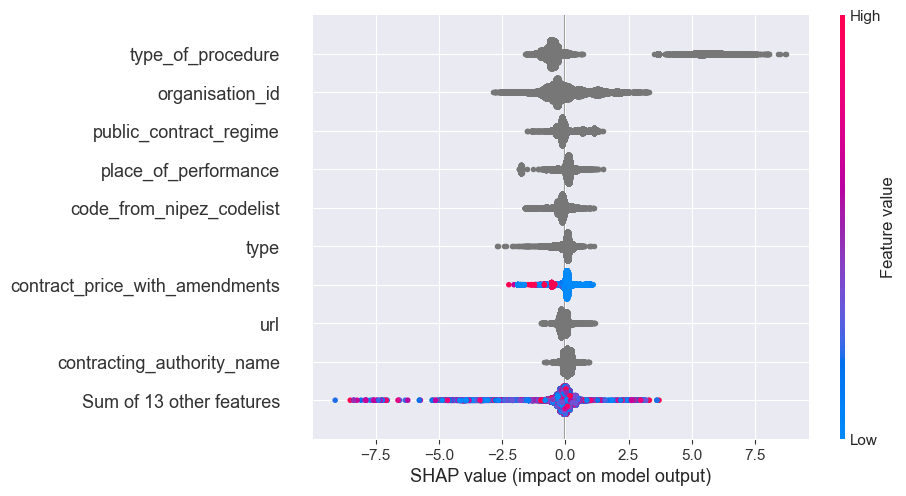

In [22]:
explainer = shap.Explainer(model_simple)
shap_values = explainer(X_train_base)
plt.close('all')
shap.plots.beeswarm(shap_values)

In [23]:
df_for_pred.drop(columns=['id', 'address_id_x', 'address_id_y', 'url', 'contracting_authority_name', 'company_id', 'code_from_nipez_codelist', 'date_of_publication', 'date_of_contract_close', 'contact_person_id', 'contracting_authority_id', 'organisation_id', 'bids_submission_deadline', 'price_vat'], inplace=True)

In [24]:
df_for_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70338 entries, 0 to 70337
Data columns (total 14 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   is_association_of_suppliers_x       70329 non-null  object 
 1   is_rejected_due_too_low             70330 non-null  object 
 2   is_withdrawn                        70329 non-null  object 
 3   price                               56137 non-null  float64
 4   contract_price                      70338 non-null  float64
 5   contract_price_vat                  70338 non-null  float64
 6   contract_price_with_amendments      70338 non-null  float64
 7   contract_price_with_amendments_vat  70338 non-null  float64
 8   is_association_of_suppliers_y       70326 non-null  object 
 9   place_of_performance                67152 non-null  object 
 10  public_contract_regime              58417 non-null  object 
 11  type                                70314

In [25]:
df_for_pred['type'].replace({np.nan : 'Unknown'}, inplace=True)
df_for_pred['type_of_procedure'].replace({np.nan : 'Unknown'}, inplace=True)
df_for_pred['public_contract_regime'].replace({np.nan : 'Unknown'}, inplace=True)
df_for_pred['place_of_performance'].replace({np.nan : 'Unknown'}, inplace=True)

In [26]:
train_data = df_for_pred.drop(columns=["is_winner"])
train_labels = df_for_pred["is_winner"]
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.20, random_state=88)

In [27]:
model = CatBoostClassifier(iterations=25,
                           depth=7,
                           learning_rate=1,
                           loss_function='Logloss',
                           verbose=True,
                           cat_features=['place_of_performance', 'public_contract_regime', 'type', 'type_of_procedure'])
# train the model
model.fit(X_train, y_train)
model.score(X_test, y_test.astype("str"))

0:	learn: 0.5562363	total: 55.2ms	remaining: 1.32s
1:	learn: 0.5375115	total: 108ms	remaining: 1.24s
2:	learn: 0.5335791	total: 160ms	remaining: 1.17s
3:	learn: 0.5240589	total: 217ms	remaining: 1.14s
4:	learn: 0.5136961	total: 264ms	remaining: 1.06s
5:	learn: 0.5041654	total: 324ms	remaining: 1.02s
6:	learn: 0.4972992	total: 375ms	remaining: 965ms
7:	learn: 0.4926702	total: 425ms	remaining: 902ms
8:	learn: 0.4908833	total: 470ms	remaining: 836ms
9:	learn: 0.4856406	total: 518ms	remaining: 778ms
10:	learn: 0.4801706	total: 570ms	remaining: 725ms
11:	learn: 0.4755542	total: 619ms	remaining: 671ms
12:	learn: 0.4717145	total: 669ms	remaining: 618ms
13:	learn: 0.4689098	total: 716ms	remaining: 562ms
14:	learn: 0.4618175	total: 765ms	remaining: 510ms
15:	learn: 0.4550571	total: 816ms	remaining: 459ms
16:	learn: 0.4502124	total: 859ms	remaining: 404ms
17:	learn: 0.4486285	total: 909ms	remaining: 354ms
18:	learn: 0.4440333	total: 955ms	remaining: 302ms
19:	learn: 0.4404368	total: 1.01s	remain

0.7703298265567244

In [28]:
predictions = model.predict(X_test)
ba = balanced_accuracy_score(y_test.astype("str"), predictions)
f1_micro = f1_score(y_test.astype("str"), predictions, average="micro")
f1_macro = f1_score(y_test.astype("str"), predictions, average="macro")
ra = roc_auc_score(y_test.astype("str"), model.predict_proba(X_test)[:,1])
print(f"Balanced accuracy: {ba}")
print(f"F1 score micro: {f1_micro}")
print(f"F1 score macro: {f1_macro}")
print(f"RocAuc score: {ra}")
print("Confusion matrix:")
display(confusion_matrix(y_test_base.astype("str"), predictions_simple))

Balanced accuracy: 0.7349944549561125
F1 score micro: 0.7703298265567244
F1 score macro: 0.743563904323368
RocAuc score: 0.8530318118923972
Confusion matrix:


array([[7989,  697],
       [2723, 2659]], dtype=int64)

In [29]:
importances = model.get_feature_importance()
feature_importances = pd.Series(importances, index=X_test.columns).sort_values(ascending=False)
feature_importances

price                                 37.322347
contract_price                        20.637356
contract_price_with_amendments        13.111800
type_of_procedure                     12.935463
contract_price_vat                     8.931627
contract_price_with_amendments_vat     2.467008
is_withdrawn                           1.329184
is_association_of_suppliers_x          1.170392
is_association_of_suppliers_y          1.140743
place_of_performance                   0.461811
type                                   0.388045
is_rejected_due_too_low                0.104223
public_contract_regime                 0.000000
dtype: float64

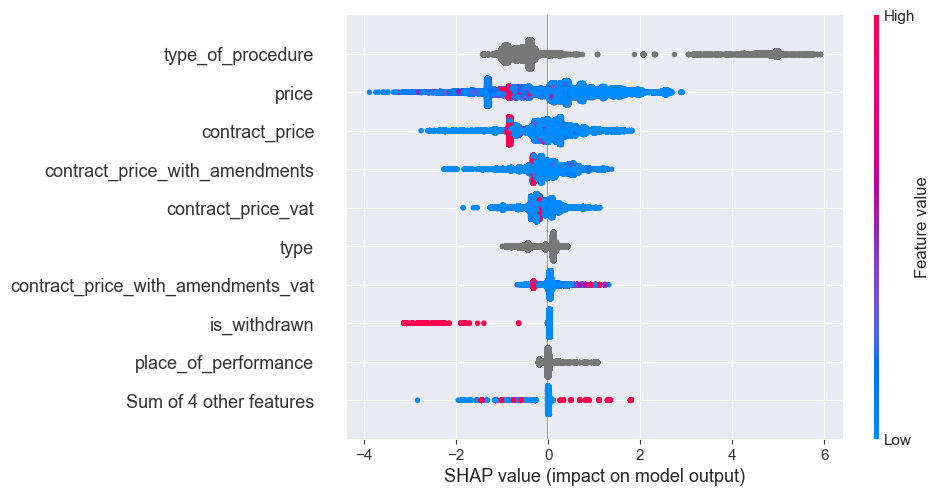

In [30]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train)
plt.close('all')
#shap.initjs()
shap.plots.beeswarm(shap_values)

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix, roc_auc_score

In [32]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train)
X_train_dummies = enc.transform(X_train)

In [33]:
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train_dummies, y_train)

In [34]:
X_test_dummies = enc.transform(X_test)
predictions = clf.predict(X_test_dummies)

In [36]:
predictions = clf.predict(X_test_dummies).astype("str")
ba = balanced_accuracy_score(y_test.astype("str"), predictions)
f1_micro = f1_score(y_test.astype("str"), predictions, average="micro")
f1_macro = f1_score(y_test.astype("str"), predictions, average="macro")
ra = roc_auc_score(y_test.astype("str"), clf.predict_proba(X_test_dummies)[:,1])
print(f"Balanced accuracy: {ba}")
print(f"F1 score micro: {f1_micro}")
print(f"F1 score macro: {f1_macro}")
print(f"RocAuc score: {ra}")

Balanced accuracy: 0.609124097834066
F1 score micro: 0.6689650270116576
F1 score macro: 0.6067126613726441
RocAuc score: 0.6470507583930984
